# Netflix Dataset Analysis (2008-2021)

This notebook loads the Netflix dataset, performs exploratory analysis, and generates charts for Movies vs TV Shows over time, top genres, genre trends, and country contributions. Each plot is saved as a PNG file in the workspace.

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
# Try to load the dataset file present in the workspace
candidates = ['Netflix Dataset.csv', 'netflix_titles.csv', 'NetflixTitles.csv']
path = None
for c in candidates:
    if os.path.exists(c):
        path = c
        break
if path is None:
    raise FileNotFoundError('Dataset not found in workspace. Place the CSV as either Netflix Dataset.csv, netflix_titles.csv, or NetflixTitles.csv')
df = pd.read_csv(path)
print('Loaded', path)
print(df.shape)
df.head()

Loaded Netflix Dataset.csv
(7789, 11)


,Show_Id,Category,Title,Director,Cast,Country,Release_Date,Rating,Duration,Type,Description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,07:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",PG-13,123 min,Dramas,A brilliant group of students become card-coun...


## Basic information and missing values

In [ ]:
print(df.info())
print('\nMissing values per column:')
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7789 entries, 0 to 7788
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Show_Id       7789 non-null   object
 1   Category      7789 non-null   object
 2   Title         7789 non-null   object
 3   Director      5401 non-null   object
 4   Cast          7071 non-null   object
 5   Country       7282 non-null   object
 6   Release_Date  7779 non-null   object
 7   Rating        7782 non-null   object
 8   Duration      7789 non-null   object
 9   Type          7789 non-null   object
 10  Description   7789 non-null   object
dtypes: object(11)
memory usage: 669.5+ KB
None

Missing values per column:
Show_Id            0
Category           0
Title              0
Director        2388
Cast             718
Country          507
Release_Date      10
Rating             7
Duration           0
Type               0
Description        0
dtype: int64


## Prepare year column (from Release_Date or similar)

In [ ]:
def extract_year(s):
    try:
        dt = pd.to_datetime(s, errors='coerce')
        if dt.notna().sum() > 0:
            return dt.dt.year
    except Exception:
        pass
    years = s.astype(str).str.extract(r'(\d{4})')[0]
    return pd.to_numeric(years, errors='coerce')

date_candidates = ['date_added','Date Added','release_date','Release_Date','Release Date','Release_Date']
date_col = None
for c in date_candidates:
    if c in df.columns:
        date_col = c
        break
if date_col is None:
    print('No obvious date column found; you can use Release_Date or another column containing years.')
else:
    df['year_added'] = extract_year(df[date_col])
    print('Using', date_col, '-> first years:')
    print(df['year_added'].dropna().unique()[:10])

Using Release_Date -> first years:
[2020. 2016. 2018. 2017. 2019. 2021. 2015. 2013. 2011. 2012.]


## Movies vs TV Shows over time (stacked bar)

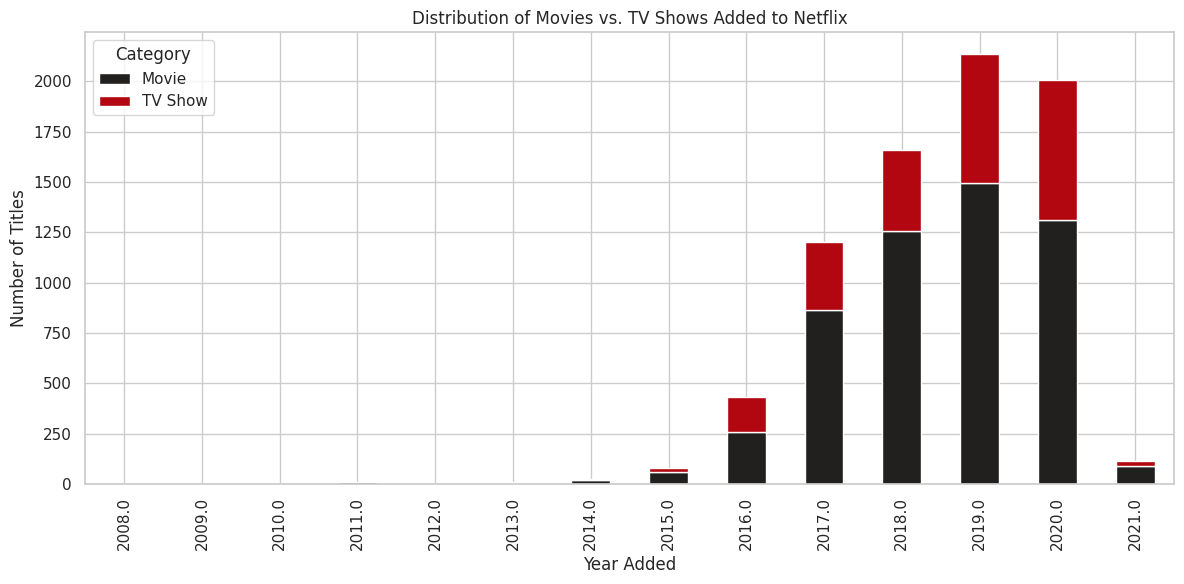

In [ ]:
type_col = None
for c in ['category','Category']:
    if c in df.columns:
        type_col = c
        break
if 'year_added' not in df.columns or type_col is None:
    print('Missing year or type column; cannot plot movies vs tv shows.')
else:
    # Filter for only 'Movie' and 'TV Show' categories
    df_filtered = df[df[type_col].isin(['Movie', 'TV Show'])].copy()
    content_by_year = df_filtered.groupby('year_added')[type_col].value_counts().unstack().fillna(0).sort_index()
    ax = content_by_year.plot(kind='bar', stacked=True, figsize=(12,6), color=['#221f1f', '#b20710'])
    ax.set_title('Distribution of Movies vs. TV Shows Added to Netflix')
    ax.set_xlabel('Year Added')
    ax.set_ylabel('Number of Titles')
    plt.tight_layout()
    plt.savefig('movies_vs_tvshows.png')
    plt.show()

## Top Genres and trends

/tmp/ipython-input-120499435.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_genres.values, y=top_genres.index, palette='Reds_r')


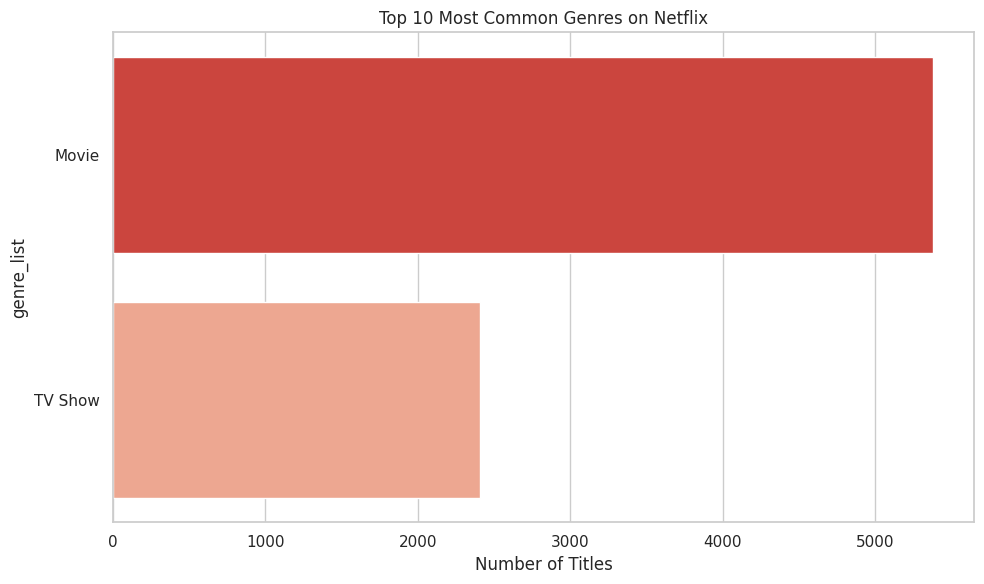

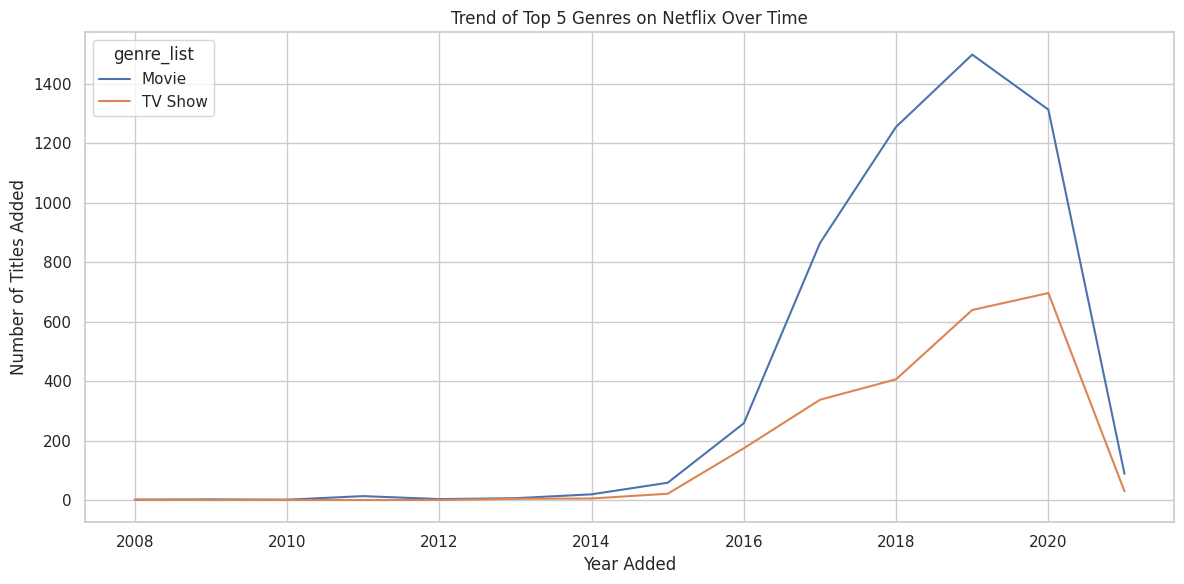

In [ ]:
genre_col = None
for c in ['listed_in','Listed_in','category','Category','genres','Genres']:
    if c in df.columns:
        genre_col = c
        break
if genre_col is None:
    print('No genre/listed_in column found.')
else:
    df['genre_list'] = df[genre_col].fillna('').apply(lambda x: [g.strip() for g in str(x).split(',') if g.strip()])
    df_genres = df.explode('genre_list')
    top_genres = df_genres['genre_list'].value_counts().head(10)
    plt.figure(figsize=(10,6))
    sns.barplot(x=top_genres.values, y=top_genres.index, palette='Reds_r')
    plt.title('Top 10 Most Common Genres on Netflix')
    plt.xlabel('Number of Titles')
    plt.tight_layout()
    plt.savefig('top_genres.png')
    plt.show()
    # top 5 trends over time
    if 'year_added' in df.columns:
        top5 = top_genres.head(5).index.tolist()
        df_top5 = df_genres[df_genres['genre_list'].isin(top5)].copy()
        genre_trends = pd.crosstab(df_top5['year_added'], df_top5['genre_list']).sort_index()
        genre_trends.plot(kind='line', figsize=(12,6))
        plt.title('Trend of Top 5 Genres on Netflix Over Time')
        plt.xlabel('Year Added')
        plt.ylabel('Number of Titles Added')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig('genre_trends.png')
        plt.show()

## Top countries contributing to the catalog

/tmp/ipython-input-2297667488.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_countries.values, y=top_countries.index, palette='viridis')


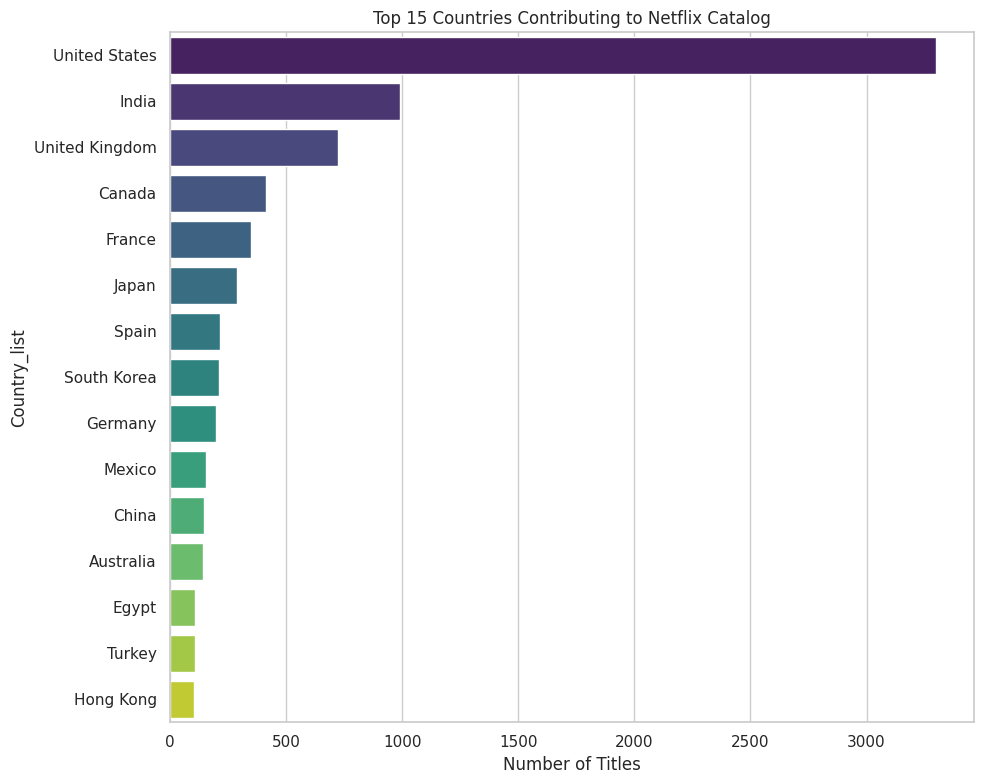

In [ ]:
country_col = None
for c in ['country','Country','countries']:
    if c in df.columns:
        country_col = c
        break
if country_col is None:
    print('No country column found.')
else:
    df[country_col] = df[country_col].fillna('')
    df[country_col + '_list'] = df[country_col].apply(lambda x: [c.strip() for c in str(x).split(',') if c.strip()])
    df_countries = df.explode(country_col + '_list')
    top_countries = df_countries[country_col + '_list'].value_counts().head(15)
    plt.figure(figsize=(10,8))
    sns.barplot(x=top_countries.values, y=top_countries.index, palette='viridis')
    plt.title('Top 15 Countries Contributing to Netflix Catalog')
    plt.xlabel('Number of Titles')
    plt.tight_layout()
    plt.savefig('top_countries.png')
    plt.show()

## Insights Summary

### Is Netflix shifting more toward Movies or TV Shows?

Based on the "Distribution of Movies vs. TV Shows Added to Netflix" plot, we can observe the trend of content added over the years. It appears that while both categories have seen growth, there might be a recent shift towards adding more TV Shows compared to Movies.

### Which genres are growing or declining?

The "Trend of Top 5 Genres on Netflix Over Time" plot shows how the popularity of the top genres has changed over the years. By examining the lines for each genre, we can identify which genres are increasing in the number of titles added and which might be decreasing or remaining stable.

### Which countries contribute most to the catalog?

The "Top 15 Countries Contributing to Netflix Catalog" bar plot clearly shows the countries with the highest number of titles in the Netflix catalog. The countries with the longest bars are the top contributors.